<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-information-from-GFF-file" data-toc-modified-id="Get-information-from-GFF-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get information from GFF file</a></span><ul class="toc-item"><li><span><a href="#Convert-GFF-to-Pandas-DataFrame" data-toc-modified-id="Convert-GFF-to-Pandas-DataFrame-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Convert GFF to Pandas DataFrame</a></span></li></ul></li><li><span><a href="#KEGG-and-COGs" data-toc-modified-id="KEGG-and-COGs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>KEGG and COGs</a></span><ul class="toc-item"><li><span><a href="#Generate-nucleotide-fasta-files-for-CDS" data-toc-modified-id="Generate-nucleotide-fasta-files-for-CDS-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate nucleotide fasta files for CDS</a></span></li><li><span><a href="#Run-EggNOG-Mapper" data-toc-modified-id="Run-EggNOG-Mapper-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run EggNOG Mapper</a></span></li><li><span><a href="#Get-KEGG-attributes" data-toc-modified-id="Get-KEGG-attributes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get KEGG attributes</a></span></li><li><span><a href="#Save-KEGG-information" data-toc-modified-id="Save-KEGG-information-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Save KEGG information</a></span></li><li><span><a href="#Save-COGs-to-annotation-dataframe" data-toc-modified-id="Save-COGs-to-annotation-dataframe-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save COGs to annotation dataframe</a></span></li></ul></li><li><span><a href="#Uniprot-ID-mapping" data-toc-modified-id="Uniprot-ID-mapping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Uniprot ID mapping</a></span></li><li><span><a href="#Add-Biocyc-Operon-information" data-toc-modified-id="Add-Biocyc-Operon-information-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add Biocyc Operon information</a></span><ul class="toc-item"><li><span><a href="#Assign-unique-IDs-to-operons" data-toc-modified-id="Assign-unique-IDs-to-operons-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Assign unique IDs to operons</a></span></li></ul></li><li><span><a href="#Clean-up-and-save-annotation" data-toc-modified-id="Clean-up-and-save-annotation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clean up and save annotation</a></span><ul class="toc-item"><li><span><a href="#Final-statistics" data-toc-modified-id="Final-statistics-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Final statistics</a></span></li><li><span><a href="#Fill-missing-values" data-toc-modified-id="Fill-missing-values-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Fill missing values</a></span></li></ul></li><li><span><a href="#GO-Annotations" data-toc-modified-id="GO-Annotations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>GO Annotations</a></span></li></ul></div>

In [1]:
import sys
sys.path.append('..')

In [1]:
import pymodulon
from pymodulon.gene_util import *
import os
from Bio import SeqIO

In [2]:
pymodulon.__path__

['/home/tahani/pymodulon/src/pymodulon']

In [8]:
org_dir = '/home/tahani/Documents/elongatus/data/'
kegg_organism_code = 'syf'
seq_dir = '/home/tahani/Documents/elongatus/sequence_files/'

# Get information from GFF file

## Convert GFF to Pandas DataFrame

In [9]:
annot_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.gff3'):
        gff = os.path.join(seq_dir,filename)
        annot_list.append(gff2pandas(gff))
keep_cols = ['accession','start','end','strand','gene_name','locus_tag','old_locus_tag','gene_product','ncbi_protein']
DF_annot = pd.concat(annot_list)[keep_cols]
DF_annot = DF_annot.drop_duplicates('locus_tag')
DF_annot.set_index('locus_tag',drop=True,inplace=True)

In [11]:
tpm_file = os.path.join(org_dir,'0_log_tpm.csv')
DF_log_tpm = pd.read_csv(tpm_file,index_col=0)

Check that the genes are the same in the expression dataset as in the annotation dataframe.

In [12]:
# Mismatched genes are listed below
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


# KEGG and COGs

## Generate nucleotide fasta files for CDS

In [7]:
cds_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.fasta'):
        fasta = os.path.join(seq_dir,filename)
        seq = SeqIO.read(fasta,'fasta')
        
        # Get gene information for genes in this fasta file
        df_genes = DF_annot[DF_annot.accession == seq.id]
        for i,row in df_genes.iterrows():
            cds = seq[row.start-1:row.end]
            if row.strand == '-':
                cds = seq[row.start-1:row.end].reverse_complement()
            cds.id = row.name
            cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
            cds_list.append(cds)

ValueError: More than one record found in handle

In [ ]:
SeqIO.write(cds_list,os.path.join(seq_dir,'CDS.fna'),'fasta')

## Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file to `<org_dir>/data/eggNOG.annotations`

## Get KEGG attributes

In [9]:
DF_eggnog = pd.read_csv(os.path.join(org_dir,'Synechococcus_elongatus.annotations'),sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

In [10]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

,gene_id,database,kegg_id
1440,SYNPCC7942_RS00005,KEGG_pathway,map00230
1441,SYNPCC7942_RS00005,KEGG_pathway,map00240
1442,SYNPCC7942_RS00005,KEGG_pathway,map01100
1443,SYNPCC7942_RS00005,KEGG_pathway,map03030
1444,SYNPCC7942_RS00005,KEGG_pathway,map03430


## Save KEGG information

In [11]:
DF_kegg.to_csv(os.path.join(org_dir,'2_kegg_mapping.csv'))

## Save COGs to annotation dataframe

In [12]:
DF_annot['COG'] = DF_eggnog.COG

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

In [13]:
DF_annot

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG
locus_tag,,,,,,,,,
SYNPCC7942_RS00005,NC_007604.1,65,1237,+,None,Synpcc7942_0001,DNA polymerase III subunit beta,WP_011243806.1,L
SYNPCC7942_RS00010,NC_007604.1,1262,2134,+,None,Synpcc7942_0002,hypothetical protein,WP_011243805.1,S
SYNPCC7942_RS00015,NC_007604.1,2178,4511,+,purL,Synpcc7942_0003,phosphoribosylformylglycinamidine synthase sub...,WP_011243804.1,F
SYNPCC7942_RS00020,NC_007604.1,4596,6077,+,None,Synpcc7942_0004,amidophosphoribosyltransferase,WP_011243803.1,F
SYNPCC7942_RS00025,NC_007604.1,6111,7706,-,None,Synpcc7942_0005,permease,WP_011377397.1,P
...,...,...,...,...,...,...,...,...,...
ST32046_p9,NC_004990.1,574,1137,-,None,pUH24_09,hypothetical protein,NP_862720.1,NaN
ST32046_p4,NC_004990.1,1485,1928,+,pmaA,pUH24_04,hypothetical protein,NP_862721.1,NaN
ST32046_p5,NC_004990.1,1938,2483,+,pmaB,pUH24_05,hypothetical protein,NP_862722.1,NaN


# Uniprot ID mapping

In [14]:
# Try the uniprot ID mapping tool - Use EMBL for Genbank file and P_REFSEQ_AC for Refseq file
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='P_REFSEQ_AC',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')

# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
assert(len(DF_annot) == len(DF_annot))

In [15]:
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
SYNPCC7942_RS00005,NC_007604.1,65,1237,+,None,Synpcc7942_0001,DNA polymerase III subunit beta,WP_011243806.1,L,UPI000049B79B
SYNPCC7942_RS00010,NC_007604.1,1262,2134,+,None,Synpcc7942_0002,hypothetical protein,WP_011243805.1,S,A0A0H3K3Q0
SYNPCC7942_RS00015,NC_007604.1,2178,4511,+,purL,Synpcc7942_0003,phosphoribosylformylglycinamidine synthase sub...,WP_011243804.1,F,Q55041
SYNPCC7942_RS00020,NC_007604.1,4596,6077,+,None,Synpcc7942_0004,amidophosphoribosyltransferase,WP_011243803.1,F,A0A0H3K6A8
SYNPCC7942_RS00025,NC_007604.1,6111,7706,-,None,Synpcc7942_0005,permease,WP_011377397.1,P,Q31SD2


# Add Biocyc Operon information

To obtain operon information, follow the steps below
1. Go to Biocyc.org (you may need to create an account and/or login)
2. Change the organism database to your organism/strain
3. Select SmartTables -> Special SmartTables
4. Select "All genes of <organism>"
5. Select the "Gene Name" column
6. Under "ADD TRANSFORM COLUMN" select "Genes in same transcription unit"
7. Select the "Genes in same transcription unit" column
8. Under "ADD PROPERTY COLUMN" select "Accession-1"
9. Under OPERATIONS, select "Export" -> "to Spreadsheet File..."
10. Select "common names" and click "Export smarttable"
11. Move file to "<org_dir>/data/" and name it as "biocyc_operon_annotations.txt"
12. Run the code cell below this

In [16]:
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
SYNPCC7942_RS00005,NC_007604.1,65,1237,+,None,Synpcc7942_0001,DNA polymerase III subunit beta,WP_011243806.1,L,UPI000049B79B
SYNPCC7942_RS00010,NC_007604.1,1262,2134,+,None,Synpcc7942_0002,hypothetical protein,WP_011243805.1,S,A0A0H3K3Q0
SYNPCC7942_RS00015,NC_007604.1,2178,4511,+,purL,Synpcc7942_0003,phosphoribosylformylglycinamidine synthase sub...,WP_011243804.1,F,Q55041
SYNPCC7942_RS00020,NC_007604.1,4596,6077,+,None,Synpcc7942_0004,amidophosphoribosyltransferase,WP_011243803.1,F,A0A0H3K6A8
SYNPCC7942_RS00025,NC_007604.1,6111,7706,-,None,Synpcc7942_0005,permease,WP_011377397.1,P,Q31SD2


In [29]:
DF_biocyc = pd.read_csv(os.path.join(org_dir,'biocyc_operons_annotations.txt'),sep='\t')
DF_biocyc = DF_biocyc.set_index('Accession-2').sort_values('Left-End-Position')
DF_biocyc

,Gene Name,Accession-1,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Object_ID
Accession-2,,,,,,,
SYNPCC7942_RS13335,anL30,NaN,65,394,putative nucleotidyltransferase,anL30,SYNPCC7942_B2615
SYNPCC7942_RS00005,dnaN,NaN,65,1237,"DNA polymerase III, &beta; subunit",SYNPCC7942_0002 // dnaN,SYNPCC7942_0001
SYNPCC7942_RS13640,parB,NaN,497,1321,partitioning protein ParB,parA // parB,SYNPCC7942_B2626
SYNPCC7942_RS00010,SYNPCC7942_0002,NaN,1262,2134,hypothetical protein,SYNPCC7942_0002 // dnaN,SYNPCC7942_0002
SYNPCC7942_RS13345,parA,NaN,1318,1929,partitioning protein ParA,parA // parB,SYNPCC7942_B2637
...,...,...,...,...,...,...,...
SYNPCC7942_RS13290,SYNPCC7942_2609,NaN,2691626,2692156,conserved hypothetical protein,SYNPCC7942_2609,SYNPCC7942_2609
SYNPCC7942_RS13295,cobA1,NaN,2692153,2692950,uroporphyrin-III C-methyltransferase,cobA1,SYNPCC7942_2610
SYNPCC7942_RS13300,SYNPCC7942_2611,NaN,2692993,2693757,conserved hypothetical protein,SYNPCC7942_2611,SYNPCC7942_2611


In [30]:
DF_biocyc = DF_biocyc.loc[~DF_biocyc.index.duplicated(keep="first")]
DF_biocyc

,Gene Name,Accession-1,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Object_ID
Accession-2,,,,,,,
SYNPCC7942_RS13335,anL30,NaN,65,394,putative nucleotidyltransferase,anL30,SYNPCC7942_B2615
SYNPCC7942_RS00005,dnaN,NaN,65,1237,"DNA polymerase III, &beta; subunit",SYNPCC7942_0002 // dnaN,SYNPCC7942_0001
SYNPCC7942_RS13640,parB,NaN,497,1321,partitioning protein ParB,parA // parB,SYNPCC7942_B2626
SYNPCC7942_RS00010,SYNPCC7942_0002,NaN,1262,2134,hypothetical protein,SYNPCC7942_0002 // dnaN,SYNPCC7942_0002
SYNPCC7942_RS13345,parA,NaN,1318,1929,partitioning protein ParA,parA // parB,SYNPCC7942_B2637
...,...,...,...,...,...,...,...
SYNPCC7942_RS13290,SYNPCC7942_2609,NaN,2691626,2692156,conserved hypothetical protein,SYNPCC7942_2609,SYNPCC7942_2609
SYNPCC7942_RS13295,cobA1,NaN,2692153,2692950,uroporphyrin-III C-methyltransferase,cobA1,SYNPCC7942_2610
SYNPCC7942_RS13300,SYNPCC7942_2611,NaN,2692993,2693757,conserved hypothetical protein,SYNPCC7942_2611,SYNPCC7942_2611


In [31]:
# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(list(DF_annot.index))
DF_biocyc

,Gene Name,Accession-1,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Object_ID
Accession-2,,,,,,,
SYNPCC7942_RS00005,dnaN,NaN,65.0,1237.0,"DNA polymerase III, &beta; subunit",SYNPCC7942_0002 // dnaN,SYNPCC7942_0001
SYNPCC7942_RS00010,SYNPCC7942_0002,NaN,1262.0,2134.0,hypothetical protein,SYNPCC7942_0002 // dnaN,SYNPCC7942_0002
SYNPCC7942_RS00015,purL,NaN,2178.0,4511.0,phosphoribosylformylglycinamidine synthase II,purL // purF,SYNPCC7942_0003
SYNPCC7942_RS00020,purF,NaN,4596.0,6077.0,amidophosphoribosyltransferase,purL // purF,SYNPCC7942_0004
SYNPCC7942_RS00025,SYNPCC7942_0005,NaN,6111.0,7706.0,conserved hypothetical protein,SYNPCC7942_0005,SYNPCC7942_0005
...,...,...,...,...,...,...,...
ST32046_p9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ST32046_p4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ST32046_p5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Assign unique IDs to operons

In [32]:
counter = 0
operon_name_mapper = {}
operon_list = []
for i,row in DF_biocyc.iterrows():
    operon = row["Genes in same transcription unit"]
    if operon not in operon_name_mapper.keys() or pd.isnull(operon):
        counter += 1
        operon_name_mapper[operon] = "Op"+str(counter)
    operon_list.append(operon_name_mapper[operon])

In [33]:
# Add operons to annotation file

DF_biocyc['operon'] = operon_list
DF_annot['operon'] = DF_biocyc['operon']
DF_biocyc

,Gene Name,Accession-1,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Object_ID,operon
Accession-2,,,,,,,,
SYNPCC7942_RS00005,dnaN,NaN,65.0,1237.0,"DNA polymerase III, &beta; subunit",SYNPCC7942_0002 // dnaN,SYNPCC7942_0001,Op1
SYNPCC7942_RS00010,SYNPCC7942_0002,NaN,1262.0,2134.0,hypothetical protein,SYNPCC7942_0002 // dnaN,SYNPCC7942_0002,Op1
SYNPCC7942_RS00015,purL,NaN,2178.0,4511.0,phosphoribosylformylglycinamidine synthase II,purL // purF,SYNPCC7942_0003,Op2
SYNPCC7942_RS00020,purF,NaN,4596.0,6077.0,amidophosphoribosyltransferase,purL // purF,SYNPCC7942_0004,Op2
SYNPCC7942_RS00025,SYNPCC7942_0005,NaN,6111.0,7706.0,conserved hypothetical protein,SYNPCC7942_0005,SYNPCC7942_0005,Op3
...,...,...,...,...,...,...,...,...
ST32046_p9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Op1992
ST32046_p4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Op1993
ST32046_p5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Op1994


# Clean up and save annotation

In [34]:
# Temporarily remove warning
pd.set_option('mode.chained_assignment', None)

In [35]:
# Reorder annotation file
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','accession','old_locus_tag','start','end','strand','gene_product','COG','uniprot','operon']
else:
    order = ['gene_name','accession','start','end','strand','gene_product','COG','uniprot','operon']
    
DF_annot = DF_annot[order]

In [36]:
DF_annot.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
SYNPCC7942_RS00005,None,NC_007604.1,Synpcc7942_0001,65,1237,+,DNA polymerase III subunit beta,L,UPI000049B79B,Op1
SYNPCC7942_RS00010,None,NC_007604.1,Synpcc7942_0002,1262,2134,+,hypothetical protein,S,A0A0H3K3Q0,Op1
SYNPCC7942_RS00015,purL,NC_007604.1,Synpcc7942_0003,2178,4511,+,phosphoribosylformylglycinamidine synthase sub...,F,Q55041,Op2
SYNPCC7942_RS00020,None,NC_007604.1,Synpcc7942_0004,4596,6077,+,amidophosphoribosyltransferase,F,A0A0H3K6A8,Op2
SYNPCC7942_RS00025,None,NC_007604.1,Synpcc7942_0005,6111,7706,-,permease,P,Q31SD2,Op3


## Final statistics

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
sns.set_style('ticks')

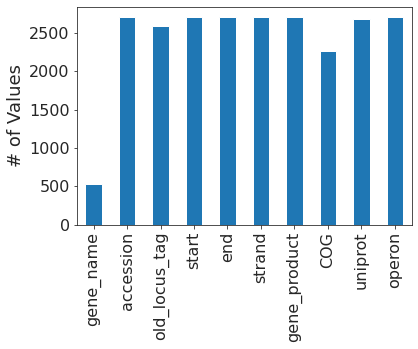

In [39]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

In [40]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

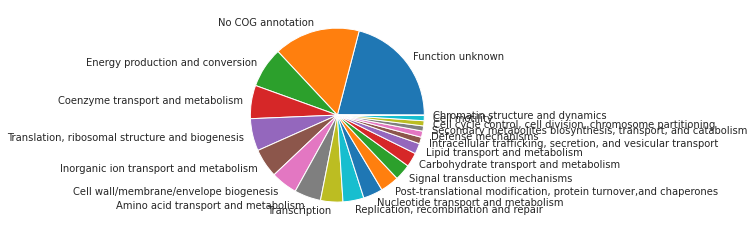

In [41]:
counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

## Adding gene names from BioCyc 

In [43]:
DF_annot
None

In [45]:
from os import path
DF_biocyc = pd.read_csv(os.path.join(org_dir,'1_biocyc_gene_annotation.csv'), sep='\t', error_bad_lines= False)

In [46]:
DF_annot['cycbio_gene_name'] = DF_annot.index
DF_annot['cycbio_gene_product'] = DF_annot.index

In [47]:
#dict(zip(df.A,df.B))
name_dict = dict(zip(DF_biocyc.locus_tag, DF_biocyc.gene_name))
product_dict = dict(zip(DF_biocyc.locus_tag, DF_biocyc.Product))

In [48]:
DF_annot = DF_annot.replace({'cycbio_gene_name':name_dict})
DF_annot = DF_annot.replace({'cycbio_gene_product':product_dict})

## Adding Maries Annotation

In [59]:
from os import path
DF_marie = pd.read_csv(os.path.join(org_dir,'marie.csv'), error_bad_lines=True)
DF_marie

,PCC7942_PG_locus,PCC7942_NCBI-alias,PCC7942_alias,PCC7942_start,PCC7942_end,PCC7942_strand,gene_name,Annotation_description,Additional description,PCC7942_essentiality,PCC7942_regulatory_region_essentiality,PCC7942_uninterupted_upstream_length,cyano_conserved,greencut2_conserved,Notes on PG Annotation
0,SE_01,SYNPCC7942_RS00005,Synpcc7942_0001,65.0,1237.0,Forward,dnaN,"DNA polymerase III, beta subunit",NaN,non-essential,NaN,NaN,yes,no,NaN
1,SE_02,SYNPCC7942_RS00010,Synpcc7942_0002,1262.0,2134.0,Forward,NaN,hypothetical protein,Uncharacterized protein YrrD,non-essential,NaN,NaN,no,no,NaN
2,SE_03,SYNPCC7942_RS00015,Synpcc7942_0003,2178.0,4511.0,Forward,purL,phosphoribosylformylglycinamidine synthase,NaN,ambiguous,NaN,NaN,yes,no,NaN
3,SE_04,SYNPCC7942_RS00020,Synpcc7942_0004,4596.0,6077.0,Forward,purF,amidophosphoribosyltransferase,NaN,essential,non-essential,0.0,yes,no,NaN
4,SE_05,SYNPCC7942_RS00025,Synpcc7942_0005,6111.0,7706.0,Reverse,NaN,"putative MFS transporter, AGZA family, xanthin...",NaN,non-essential,NaN,NaN,no,no,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABC transporter substrate-binding protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,peptide/nickel transport system permease protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
DF_marie = DF_marie.fillna('no')
DF_marie

,PCC7942_PG_locus,PCC7942_NCBI-alias,PCC7942_alias,PCC7942_start,PCC7942_end,PCC7942_strand,gene_name,Annotation_description,Additional description,PCC7942_essentiality,PCC7942_regulatory_region_essentiality,PCC7942_uninterupted_upstream_length,cyano_conserved,greencut2_conserved,Notes on PG Annotation
0,SE_01,SYNPCC7942_RS00005,Synpcc7942_0001,65.0,1237.0,Forward,dnaN,"DNA polymerase III, beta subunit",no,non-essential,no,no,yes,no,no
1,SE_02,SYNPCC7942_RS00010,Synpcc7942_0002,1262.0,2134.0,Forward,no,hypothetical protein,Uncharacterized protein YrrD,non-essential,no,no,no,no,no
2,SE_03,SYNPCC7942_RS00015,Synpcc7942_0003,2178.0,4511.0,Forward,purL,phosphoribosylformylglycinamidine synthase,no,ambiguous,no,no,yes,no,no
3,SE_04,SYNPCC7942_RS00020,Synpcc7942_0004,4596.0,6077.0,Forward,purF,amidophosphoribosyltransferase,no,essential,non-essential,0.0,yes,no,no
4,SE_05,SYNPCC7942_RS00025,Synpcc7942_0005,6111.0,7706.0,Reverse,no,"putative MFS transporter, AGZA family, xanthin...",no,non-essential,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,no,no,no,no,no,no,no,hypothetical protein,no,no,no,no,no,no,no
2922,no,no,no,no,no,no,no,hypothetical protein,no,no,no,no,no,no,no
2923,no,no,no,no,no,no,no,ABC transporter substrate-binding protein,no,no,no,no,no,no,no
2924,no,no,no,no,no,no,no,peptide/nickel transport system permease protein,no,no,no,no,no,no,no


In [62]:
DF_annot['marie_gene'] = DF_annot.index
DF_annot['marie_product'] = DF_annot.index
DF_annot['marie_annot'] = DF_annot.index

In [64]:
#dict(zip(df.A,df.B))
name_dict = dict(zip(DF_marie['PCC7942_NCBI-alias'], DF_marie['gene_name']))
product_dict = dict(zip(DF_marie['PCC7942_NCBI-alias'], DF_marie['Annotation_description']))
new_anot = dict(zip(DF_marie['PCC7942_NCBI-alias'],DF_marie['PCC7942_PG_locus']))

In [65]:
name_dict

{'SYNPCC7942_RS00005': 'dnaN',
 'SYNPCC7942_RS00010': 'no',
 'SYNPCC7942_RS00015': 'purL',
 'SYNPCC7942_RS00020': 'purF',
 'SYNPCC7942_RS00025': 'no',
 'SYNPCC7942_RS00030': 'no',
 'SYNPCC7942_RS00035': 'no',
 'SYNPCC7942_RS00040': 'no',
 'SYNPCC7942_RS00045': 'argG',
 'SYNPCC7942_RS00050': 'no',
 'SYNPCC7942_RS00055': 'no',
 'SYNPCC7942_RS00060': 'rpsF',
 'SYNPCC7942_RS00065': 'no',
 'SYNPCC7942_RS00070': 'no',
 'SYNPCC7942_RS00075': 'no',
 'SYNPCC7942_RS00080': 'no',
 'SYNPCC7942_RS00085': 'no',
 'SYNPCC7942_RS00090': 'eda',
 'SYNPCC7942_RS00095': 'glyS',
 'SYNPCC7942_RS00100': 'sir',
 'SYNPCC7942_RS00105': 'no',
 'SYNPCC7942_RS00110': 'cobK',
 'SYNPCC7942_RS00115': 'no',
 'SYNPCC7942_RS00120': 'cax',
 'SYNPCC7942_RS00125': 'no',
 'SYNPCC7942_RS00130': 'no',
 'SYNPCC7942_RS00135': 'no',
 'SYNPCC7942_RS00140': 'bioF',
 'SYNPCC7942_RS00145': 'no',
 'SYNPCC7942_RS00150': 'no',
 'SYNPCC7942_RS00155': 'bioD',
 'SYNPCC7942_RS00160': 'bioA',
 'SYNPCC7942_RS00165': 'no',
 'SYNPCC7942_RS13645

In [66]:
for key, value in name_dict.items():
    if value == 'no':
        name_dict[key] = new_anot[key]

In [ ]:
name_dict

In [69]:
DF_annot = DF_annot.replace({'marie_gene':name_dict})
DF_annot = DF_annot.replace({'marie_product':product_dict})
DF_annot = DF_annot.replace({'marie_annot':new_anot})
# DF_annot.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,cycbio_gene_name,cycbio_gene_product,marie_gene,marie_product,marie_annot
locus_tag,,,,,,,,,,,,,,,
SYNPCC7942_RS00005,SYNPCC7942_RS00005,NC_007604.1,Synpcc7942_0001,65,1237,+,DNA polymerase III subunit beta,"Replication, recombination and repair",UPI000049B79B,Op1,SYNPCC7942_RS00005,SYNPCC7942_RS00005,dnaN,"DNA polymerase III, beta subunit",SE_01
SYNPCC7942_RS00010,SYNPCC7942_RS00010,NC_007604.1,Synpcc7942_0002,1262,2134,+,hypothetical protein,Function unknown,A0A0H3K3Q0,Op1,SYNPCC7942_0002,hypothetical protein,SE_02,hypothetical protein,SE_02
SYNPCC7942_RS00015,purL,NC_007604.1,Synpcc7942_0003,2178,4511,+,phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,Q55041,Op2,purL,phosphoribosylformylglycinamidine synthase II,purL,phosphoribosylformylglycinamidine synthase,SE_03
SYNPCC7942_RS00020,SYNPCC7942_RS00020,NC_007604.1,Synpcc7942_0004,4596,6077,+,amidophosphoribosyltransferase,Nucleotide transport and metabolism,A0A0H3K6A8,Op2,purF,amidophosphoribosyltransferase,purF,amidophosphoribosyltransferase,SE_04
SYNPCC7942_RS00025,SYNPCC7942_RS00025,NC_007604.1,Synpcc7942_0005,6111,7706,-,permease,Inorganic ion transport and metabolism,Q31SD2,Op3,SYNPCC7942_0005,conserved hypothetical protein,SE_05,"putative MFS transporter, AGZA family, xanthin...",SE_05


In [74]:
order = ['old_locus_tag','marie_annot', 'marie_gene', 'marie_product', 'cycbio_gene_name','cycbio_gene_product', 
         'gene_name', 'gene_product','COG','uniprot','operon','accession','start','end','strand']
DF_annot = DF_annot[order]
DF_annot[30:38]

,old_locus_tag,marie_annot,marie_gene,marie_product,cycbio_gene_name,cycbio_gene_product,gene_name,gene_product,COG,uniprot,operon,accession,start,start,end,end,strand,strand
locus_tag,,,,,,,,,,,,,,,,,,
SYNPCC7942_RS00155,Synpcc7942_0030,SE_31,bioD,dethiobiotin synthetase,bioD,dethiobiotin synthase,bioD,dethiobiotin synthase,Coenzyme transport and metabolism,A0A0H3K9Q2,Op20,NC_007604.1,30839,30839,31471,31471,+,+
SYNPCC7942_RS00160,Synpcc7942_0031,SE_32,bioA,adenosylmethionine-8-amino-7-oxononanoate amin...,bioA,adenosylmethionine-8-amino-7-oxononanoate amin...,bioA,adenosylmethionine--8-amino-7-oxononanoate tra...,Coenzyme transport and metabolism,A0A0H3K3M1,Op20,NC_007604.1,31464,31464,32738,32738,+,+
SYNPCC7942_RS00165,Synpcc7942_0032,SE_33,SE_33,DUF86 domain-containing protein,SYNPCC7942_0032,conserved hypothetical protein,SYNPCC7942_RS00165,DUF86 domain-containing protein,Function unknown,A0A0H3K674,Op21,NC_007604.1,32849,32849,33202,33202,-,-
SYNPCC7942_RS13645,Synpcc7942_0033,SE_34,SE_34,nucleotidyltransferase family protein,SYNPCC7942_RS13645,SYNPCC7942_RS13645,SYNPCC7942_RS13645,nucleotidyltransferase family protein,Function unknown,A0A0H3K362,Op22,NC_007604.1,33174,33174,33506,33506,-,-
SYNPCC7942_RS00170,None,SE_36,SE_36,hypothetical protein,SYNPCC7942_RS00170,SYNPCC7942_RS00170,SYNPCC7942_RS00170,hypothetical protein,No COG annotation,UPI0005853E7E,Op23,NC_007604.1,33960,33960,34289,34289,+,+
SYNPCC7942_RS00175,Synpcc7942_0035,SE_37,SE_37,hypothetical protein,SYNPCC7942_0035,conserved hypothetical protein,SYNPCC7942_RS00175,hypothetical protein,No COG annotation,Q31SA2,Op24,NC_007604.1,34357,34357,35115,35115,-,-
SYNPCC7942_RS00180,None,SE_38,SE_38,hypothetical protein,SYNPCC7942_RS00180,SYNPCC7942_RS00180,SYNPCC7942_RS00180,hypothetical protein,Function unknown,Q31SA1,Op25,NC_007604.1,35341,35341,36126,36126,+,+
SYNPCC7942_RS00185,Synpcc7942_0037,SE_39,SE_39,hypothetical protein,SYNPCC7942_0037,hypothetical protein,SYNPCC7942_RS00185,hypothetical protein,No COG annotation,Q31SA0,Op26,NC_007604.1,36123,36123,36326,36326,-,-


In [75]:
DF_annot

,old_locus_tag,marie_annot,marie_gene,marie_product,cycbio_gene_name,cycbio_gene_product,gene_name,gene_product,COG,uniprot,operon,accession,start,start,end,end,strand,strand
locus_tag,,,,,,,,,,,,,,,,,,
SYNPCC7942_RS00005,Synpcc7942_0001,SE_01,dnaN,"DNA polymerase III, beta subunit",SYNPCC7942_RS00005,SYNPCC7942_RS00005,SYNPCC7942_RS00005,DNA polymerase III subunit beta,"Replication, recombination and repair",UPI000049B79B,Op1,NC_007604.1,65,65,1237,1237,+,+
SYNPCC7942_RS00010,Synpcc7942_0002,SE_02,SE_02,hypothetical protein,SYNPCC7942_0002,hypothetical protein,SYNPCC7942_RS00010,hypothetical protein,Function unknown,A0A0H3K3Q0,Op1,NC_007604.1,1262,1262,2134,2134,+,+
SYNPCC7942_RS00015,Synpcc7942_0003,SE_03,purL,phosphoribosylformylglycinamidine synthase,purL,phosphoribosylformylglycinamidine synthase II,purL,phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,Q55041,Op2,NC_007604.1,2178,2178,4511,4511,+,+
SYNPCC7942_RS00020,Synpcc7942_0004,SE_04,purF,amidophosphoribosyltransferase,purF,amidophosphoribosyltransferase,SYNPCC7942_RS00020,amidophosphoribosyltransferase,Nucleotide transport and metabolism,A0A0H3K6A8,Op2,NC_007604.1,4596,4596,6077,6077,+,+
SYNPCC7942_RS00025,Synpcc7942_0005,SE_05,SE_05,"putative MFS transporter, AGZA family, xanthin...",SYNPCC7942_0005,conserved hypothetical protein,SYNPCC7942_RS00025,permease,Inorganic ion transport and metabolism,Q31SD2,Op3,NC_007604.1,6111,6111,7706,7706,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST32046_p9,pUH24_09,ST32046_p9,ST32046_p9,ST32046_p9,ST32046_p9,ST32046_p9,ST32046_p9,hypothetical protein,No COG annotation,Q53571,Op1992,NC_004990.1,574,574,1137,1137,-,-
ST32046_p4,pUH24_04,ST32046_p4,ST32046_p4,ST32046_p4,ST32046_p4,ST32046_p4,pmaA,hypothetical protein,No COG annotation,Q53572,Op1993,NC_004990.1,1485,1485,1928,1928,+,+
ST32046_p5,pUH24_05,ST32046_p5,ST32046_p5,ST32046_p5,ST32046_p5,ST32046_p5,pmaB,hypothetical protein,No COG annotation,Q53573,Op1994,NC_004990.1,1938,1938,2483,2483,+,+


In [76]:
DF_annot.to_csv(os.path.join(org_dir,'gene_info_operon.csv'))

# GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2
1. Go to http://amigo.geneontology.org/amigo/search/annotation
1. Filter for your organism
1. Click `CustomDL`
1. Drag `GO class (direct)` to the end of your Selected Fields
1. Save as `GO_annotations.txt` in the `data` folder of your organism directory

In [85]:
DF_GO = pd.read_csv(os.path.join(org_dir,'3_go_annotation.txt'),sep='\t',header=None)

In [86]:
DF_GO = pd.read_csv(os.path.join(org_dir,'3_go_annotation.txt'),sep='\t',header=None,usecols=[3,9,18])
DF_GO.columns = ['gene_name','gene_product','gene_ontology']
DF_GO.gene_name.fillna(DF_GO.gene_name,inplace=True)
DF_GO.head()

,gene_name,gene_product,gene_ontology
0,PSK,D-ribulose kinase,ATP binding
1,PSK,D-ribulose kinase,D-ribulokinase activity
2,cbbL,Ribulose bisphosphate carboxylase large chain,carboxysome
3,Synpcc7942_0520,Uncharacterized protein,carboxysome
4,Synpcc7942_0520,Uncharacterized protein,structural constituent of carboxysome


Take a look at the `gene_id` column:
1. Make sure there are no null entries
2. Check if it uses the new or old locus tag (if applicable)

If it looks like it uses the old locus tag, set old_locus_tag to `True`

In [82]:
old_locus_tag = False

In [87]:
DF_GO[DF_GO.gene_name.isnull()]

,gene_name,gene_product,gene_ontology


In [90]:
# if not old_locus_tag:
#     convert_tags = {value:key for key,value in DF_annot.old_locus_tag.items()}
#     DF_GO.gene_name = DF_GO.gene_name.apply(lambda x: convert_tags[x])

In [91]:
DF_GO.head()

,gene_name,gene_product,gene_ontology
0,PSK,D-ribulose kinase,ATP binding
1,PSK,D-ribulose kinase,D-ribulokinase activity
2,cbbL,Ribulose bisphosphate carboxylase large chain,carboxysome
3,Synpcc7942_0520,Uncharacterized protein,carboxysome
4,Synpcc7942_0520,Uncharacterized protein,structural constituent of carboxysome


In [ ]:
# DF_GO[['gene_id','gene_ontology']].to_csv(os.path.join(org_dir,'data','GO_annotations.csv'))

In [92]:
DF_GO.to_csv(os.path.join(org_dir,'2_GO_annotations.csv'))